<h1 align="center">
MySQL access and plotting with Python (Matplotlib and Plotly)
</h1>

<h2 align="center">
Orginal version by <a href="https://moderndata.plot.ly/graph-data-from-mysql-database-in-python/">modern data</a>
</h2>

<h3 align="center">
modified by Andreas Putz
</h3>

---

**Notebook Purpose**: This notebook is a toy notebook to remove some rust from my SQL knowledgs. It's main purpose is to
* refresh my experience to install and configure mysql,
* refresh my SQL query knowledge, and
* have some fun with plots:
  * My default - *Matplotlib*. It always works, with some effort publication worthy graphs. However a little slow and interactivity looks a little old fashioned.
  * catch of the day - *Plotly* (https://plot.ly/). A web toolkit with an offline mode. This notebook uses the offline mode extensively. A little touchy at times, but works with python 3.X
  
This notebook has been run in an anaconda python 3.6 environment on an Ubuntu Linux machine. The approach in the original source did not work for me so I had to replace some packages with python 3 variations.

---

# Environment preparation

## Python environment

For this example I use an anaconda python 3.6 environmnet

    conda create -n py36 python=3.6 anaconda 
    conda install plotly pymysql
    
## Mysql environment

* Setup a mysql server on your box
* Load the world dataset into your mysql instance (see https://dev.mysql.com/doc/world-setup/en/world-setup-installation.html)
* Allow a guest user with password guest read access to the WORLD database.
* Play

## Package imports and some tests

In [1]:
import scipy as sp
import pandas as pd

import pylab as plt
%matplotlib notebook 

#--------------------------------------
# Needs a little more work
# For the Plotly example: https://plot.ly/python/graph-data-from-mysql-database-in-python/
#--------------------------------------
import plotly
import plotly.plotly as py
from plotly.graph_objs import *
plotly.offline.init_notebook_mode(connected=True)
#plotly.offline.init_notebook_mode()
print('Plotly Version: ', plotly.__version__)


# Does not currently work with Python 3.X
#import sqlalchemy as sqla
#from sqlalchemy import create_engine

# Python 3.X workaround
import pymysql
import pymysql.cursors

Plotly Version:  2.0.11


In [2]:
from itertools import chain

In [3]:
plotly.offline.iplot([{"x": [1, 2, 3], "y": [3, 1, 6]}])

# Exploring the WORLD Dataset

## Establish Database Connection

In [4]:
conn = pymysql.connect(host='localhost',user='guest',password='guest',db='world')
cursor = conn.cursor()

In [5]:
cursor.execute('SHOW TABLES')
output = cursor.fetchall()
output

(('city',), ('country',), ('countrylanguage',))

In [6]:
cursor.execute('DESCRIBE country')
output = cursor.fetchall()
output

(('Code', 'char(3)', 'NO', 'PRI', '', ''),
 ('Name', 'char(52)', 'NO', '', '', ''),
 ('Continent',
  "enum('Asia','Europe','North America','Africa','Oceania','Antarctica','South America')",
  'NO',
  '',
  'Asia',
  ''),
 ('Region', 'char(26)', 'NO', '', '', ''),
 ('SurfaceArea', 'float(10,2)', 'NO', '', '0.00', ''),
 ('IndepYear', 'smallint(6)', 'YES', '', None, ''),
 ('Population', 'int(11)', 'NO', '', '0', ''),
 ('LifeExpectancy', 'float(3,1)', 'YES', '', None, ''),
 ('GNP', 'float(10,2)', 'YES', '', None, ''),
 ('GNPOld', 'float(10,2)', 'YES', '', None, ''),
 ('LocalName', 'char(45)', 'NO', '', '', ''),
 ('GovernmentForm', 'char(45)', 'NO', '', '', ''),
 ('HeadOfState', 'char(60)', 'YES', '', None, ''),
 ('Capital', 'int(11)', 'YES', '', None, ''),
 ('Code2', 'char(2)', 'NO', '', '', ''))

##  Query country database

In [7]:
cursor.execute('SELECT Name, Continent, Population, LifeExpectancy, GNP FROM country');
rows = cursor.fetchall()
rows[1:4]

(('Afghanistan', 'Asia', 22720000, 45.9, 5976.0),
 ('Angola', 'Africa', 12878000, 38.3, 6648.0),
 ('Anguilla', 'North America', 8000, 76.1, 63.2))

In [8]:
# This is a dirty and slow way to do this, use more sophisticated pandas and scipy to do this
df = pd.DataFrame( [[ij for ij in i] for i in rows] )
df.rename(columns={0: 'Name', 1: 'Continent', 2: 'Population', 3: 'LifeExpectancy', 4:'GNP'}, inplace=True);
df = df.sort_values(by=['LifeExpectancy'], ascending=[1]);

In [9]:
df[0:10]

Name Continent  Population  LifeExpectancy     GNP
237      Zambia    Africa     9169000            37.2  3377.0
143  Mozambique    Africa    19680000            37.5  2891.0
148      Malawi    Africa    10925000            37.6  1687.0
238    Zimbabwe    Africa    11669000            37.8  5951.0
2        Angola    Africa    12878000            38.3  6648.0
35     Botswana    Africa     1622000            39.3  4834.0
182      Rwanda    Africa     7733000            39.3  2036.0
201   Swaziland    Africa     1008000            40.4  1206.0
153       Niger    Africa    10730000            41.3  1706.0
151     Namibia    Africa     1726000            42.5  3101.0

In [10]:
mycolors = df['Continent']*0+'black'
mycolors[df['Continent']=='Africa']='red'
mycolors[df['Continent']=='Asia']='green'
mycolors[df['Continent']=='North America']='blue'
mycolors[df['Continent']=='South America']='lightblue'
mycolors[df['Continent']=='Europe']='yellow'


<IPython.core.display.Javascript object>


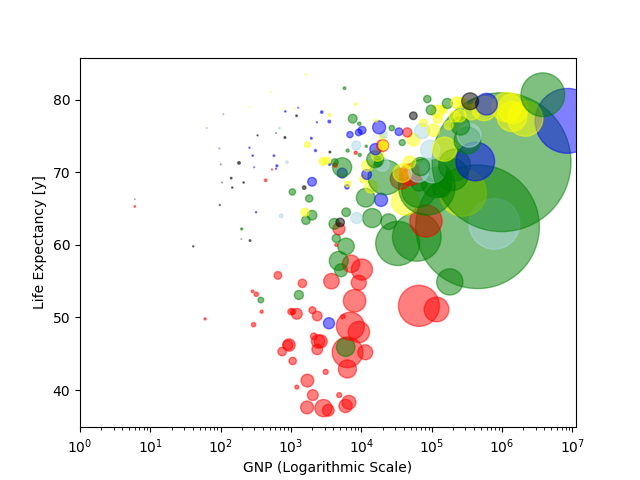

In [11]:
# Matplotib Plots
plt.figure()
axes = plt.gca()
plt.scatter(df['GNP'],df['LifeExpectancy'], s=df['Population']/df['Population'].max()*10000 ,c=mycolors,alpha=0.5)
axes.set_xscale('log')
axes.set_xlim(left=1)
plt.xlabel('GNP (Logarithmic Scale)')
plt.ylabel('Life Expectancy [y]')
plt.show()

In [12]:
#Plotly Plots
trace1 = Scatter(
    x=df['GNP'],
    y=df['LifeExpectancy'],
    text=df['Name'],
    mode='markers'
)
layout = Layout(
    title='Life expectancy vs GNP from MySQL world database',
    xaxis=XAxis( type='log', title='GNP' ),
    yaxis=YAxis( title='Life expectancy' ),
)
data = Data([trace1])
fig = Figure(data=data, layout=layout)
plotly.offline.iplot(fig, filename='world GNP vs life expectancy')

In [13]:
# (!) Set 'size' values to be proportional to rendered area,
#     instead of diameter. This makes the range of bubble sizes smaller
sizemode='area'       

# (!) Set a reference for 'size' values (i.e. a population-to-pixel scaling).
#     Here the max bubble area will be on the order of 100 pixels
sizeref=df['Population'].max()/1e2**2

colors = {
    'Asia':"rgb(255,65,54)", 
    'Europe':"rgb(133,20,75)",
    'Africa':"rgb(0,116,217)",
    'North America':"rgb(255,133,27)",
    'South America':"rgb(23,190,207)",
    'Antarctica':"rgb(61,153,112)",
    'Oceania':"rgb(255,220,0)",
}

# Define a hover-text generating function (returns a list of strings)
def make_text(X):
    return 'Country: %s\
    <br>Life Expectancy: %s years\
    <br>Population: %s million'\
    % (X['Name'], X['LifeExpectancy'], X['Population']/1e6)  

# Define a trace-generating function (returns a Scatter object)
def make_trace(X, continent, sizes, color):  
    return Scatter(
        x=X['GNP'],  # GDP on the x-xaxis
        y=X['LifeExpectancy'],    # life Exp on th y-axis
        name=continent,    # label continent names on hover
        mode='markers',    # (!) point markers only on this plot
        text=X.apply(make_text, axis=1).tolist(),
        marker= Marker(
            color=color,           # marker color
            size=sizes,            # (!) marker sizes (sizes is a list)
            sizeref=sizeref,       # link sizeref
            sizemode=sizemode,     # link sizemode
            opacity=0.6,           # (!) partly transparent markers
            line= Line(width=3,color="white")  # marker borders
        )
    )

# Initialize data object 
data = Data()

# Group data frame by continent sub-dataframe (named X), 
#   make one trace object per continent and append to data object
for continent, X in df.groupby('Continent'):
    
    sizes = X['Population']                 # get population array 
    color = colors[continent]               # get bubble color
    
    data.append(
        make_trace(X, continent, sizes, color)  # append trace to data object
    ) 

    # Set plot and axis titles
title = "Life expectancy vs GNP from MySQL world database (bubble chart)"
x_title = "Gross National Product"
y_title = "Life Expectancy [in years]"

# Define a dictionary of axis style options
axis_style = dict(  
    type='log',
    zeroline=False,       # remove thick zero line
    gridcolor='#FFFFFF',  # white grid lines
    ticks='outside',      # draw ticks outside axes 
    ticklen=8,            # tick length
    tickwidth=1.5         #   and width
)

# Make layout object
layout = Layout(
    title=title,             # set plot title
    plot_bgcolor='#EFECEA',  # set plot color to grey
    hovermode="closest",
    xaxis=XAxis(
        axis_style,      # add axis style dictionary
        title=x_title,   # x-axis title
        range=[2.0,7.2], # log of min and max x limits
    ),
    yaxis=YAxis(
        axis_style,      # add axis style dictionary
        title=y_title,   # y-axis title
    )
)

# Make Figure object
fig = Figure(data=data, layout=layout)

# (@) Send to Plotly and show in notebook
plotly.offline.iplot(fig, filename='s3_life-gdp')

## Combine City and Country Data

In [14]:
cursor.execute('SHOW TABLES')
output = cursor.fetchall()
output

(('city',), ('country',), ('countrylanguage',))

In [15]:
cursor.execute('DESCRIBE city')
output = cursor.fetchall()
output

(('ID', 'int(11)', 'NO', 'PRI', None, 'auto_increment'),
 ('Name', 'char(35)', 'NO', '', '', ''),
 ('CountryCode', 'char(3)', 'NO', 'MUL', '', ''),
 ('District', 'char(20)', 'NO', '', '', ''),
 ('Population', 'int(11)', 'NO', '', '0', ''))

In [16]:
cursor.execute('DESCRIBE countrylanguage')
output = cursor.fetchall()
output

(('CountryCode', 'char(3)', 'NO', 'PRI', '', ''),
 ('Language', 'char(30)', 'NO', 'PRI', '', ''),
 ('IsOfficial', "enum('T','F')", 'NO', '', 'F', ''),
 ('Percentage', 'float(4,1)', 'NO', '', '0.0', ''))

In [17]:
cursor.execute('DESCRIBE country')
output = cursor.fetchall()
output

(('Code', 'char(3)', 'NO', 'PRI', '', ''),
 ('Name', 'char(52)', 'NO', '', '', ''),
 ('Continent',
  "enum('Asia','Europe','North America','Africa','Oceania','Antarctica','South America')",
  'NO',
  '',
  'Asia',
  ''),
 ('Region', 'char(26)', 'NO', '', '', ''),
 ('SurfaceArea', 'float(10,2)', 'NO', '', '0.00', ''),
 ('IndepYear', 'smallint(6)', 'YES', '', None, ''),
 ('Population', 'int(11)', 'NO', '', '0', ''),
 ('LifeExpectancy', 'float(3,1)', 'YES', '', None, ''),
 ('GNP', 'float(10,2)', 'YES', '', None, ''),
 ('GNPOld', 'float(10,2)', 'YES', '', None, ''),
 ('LocalName', 'char(45)', 'NO', '', '', ''),
 ('GovernmentForm', 'char(45)', 'NO', '', '', ''),
 ('HeadOfState', 'char(60)', 'YES', '', None, ''),
 ('Capital', 'int(11)', 'YES', '', None, ''),
 ('Code2', 'char(2)', 'NO', '', '', ''))

In [18]:
myQuery = '''SELECT `COLUMN_NAME`
           FROM `INFORMATION_SCHEMA`.`COLUMNS`
           WHERE `TABLE_SCHEMA`='world'
           AND `TABLE_NAME`='city'
           OR `TABLE_NAME`='country'
           '''
cursor.execute(myQuery)
headers = cursor.fetchall()
headers

(('country_id',),
 ('country',),
 ('last_update',),
 ('ID',),
 ('Name',),
 ('CountryCode',),
 ('District',),
 ('Population',),
 ('Code',),
 ('Name',),
 ('Continent',),
 ('Region',),
 ('SurfaceArea',),
 ('IndepYear',),
 ('Population',),
 ('LifeExpectancy',),
 ('GNP',),
 ('GNPOld',),
 ('LocalName',),
 ('GovernmentForm',),
 ('HeadOfState',),
 ('Capital',),
 ('Code2',))

In [19]:
myQuery = '''SELECT `COLUMN_NAME`
           FROM `INFORMATION_SCHEMA`.`COLUMNS`
           WHERE `TABLE_SCHEMA`='world'
           AND `TABLE_NAME`='city'
           '''
cursor.execute(myQuery)
headers = cursor.fetchall()

myQuery = '''SELECT `COLUMN_NAME`
           FROM `INFORMATION_SCHEMA`.`COLUMNS`
           WHERE `TABLE_SCHEMA`='world'
           AND `TABLE_NAME`='country'
           '''
cursor.execute(myQuery)
headers += cursor.fetchall()

headers = list(chain.from_iterable(headers))
headers

['ID',
 'Name',
 'CountryCode',
 'District',
 'Population',
 'Code',
 'Name',
 'Continent',
 'Region',
 'SurfaceArea',
 'IndepYear',
 'Population',
 'LifeExpectancy',
 'GNP',
 'GNPOld',
 'LocalName',
 'GovernmentForm',
 'HeadOfState',
 'Capital',
 'Code2']

In [20]:
myQuery = '''SELECT *
           FROM city AS first
           JOIN country AS second
           ON first.CountryCode = second.Code
           '''
cursor.execute(myQuery)
output = list(map(list, cursor))
len(output)

df = pd.DataFrame.from_records(output,columns=headers)
df = df.set_index('ID')
df = df.sort_index()

df[0:5]

Name CountryCode       District  Population Code         Name  \
ID                                                                            
1            Kabul         AFG          Kabol     1780000  AFG  Afghanistan   
2         Qandahar         AFG       Qandahar      237500  AFG  Afghanistan   
3            Herat         AFG          Herat      186800  AFG  Afghanistan   
4   Mazar-e-Sharif         AFG          Balkh      127800  AFG  Afghanistan   
5        Amsterdam         NLD  Noord-Holland      731200  NLD  Netherlands   

   Continent                     Region  SurfaceArea  IndepYear  Population  \
ID                                                                            
1       Asia  Southern and Central Asia     652090.0     1919.0    22720000   
2       Asia  Southern and Central Asia     652090.0     1919.0    22720000   
3       Asia  Southern and Central Asia     652090.0     1919.0    22720000   
4       Asia  Southern and Central Asia     652090.0     1919.0    22720000   
5     Europe             Western Europe      41526.0     1581.0    15864000   

    LifeExpectancy       GNP    GNPOld              LocalName  \
ID                                                              
1             45.9    5976.0       NaN  Afganistan/Afqanestan   
2             45.9    5976.0       NaN  Afganistan/Afqanestan   
3             45.9    5976.0       NaN  Afganistan/Afqanestan   
4             45.9    5976.0       NaN  Afganistan/Afqanestan   
5             78.3  371362.0  360478.0              Nederland   

             GovernmentForm    HeadOfState  Capital Code2  
ID                                                         
1           Islamic Emirate  Mohammad Omar        1    AF  
2           Islamic Emirate  Mohammad Omar        1    AF  
3           Islamic Emirate  Mohammad Omar        1    AF  
4           Islamic Emirate  Mohammad Omar        1    AF  
5   Constitutional Monarchy        Beatrix        5    NL

In [21]:
myQuery = '''SELECT *
           FROM city AS first
           JOIN country AS second
           ON first.CountryCode = second.Code
           WHERE first.ID = second.Capital
           '''
cursor.execute(myQuery)
output = list(map(list, cursor))
len(output)

df = pd.DataFrame.from_records(output,columns=headers)
df = df.set_index('ID')
df = df.sort_index()

df[0:5]

Name CountryCode       District  Population Code  \
ID                                                           
1        Kabul         AFG          Kabol     1780000  AFG   
5    Amsterdam         NLD  Noord-Holland      731200  NLD   
33  Willemstad         ANT        Curaçao        2345  ANT   
34      Tirana         ALB         Tirana      270000  ALB   
35       Alger         DZA          Alger     2168000  DZA   

                    Name      Continent                     Region  \
ID                                                                   
1            Afghanistan           Asia  Southern and Central Asia   
5            Netherlands         Europe             Western Europe   
33  Netherlands Antilles  North America                  Caribbean   
34               Albania         Europe            Southern Europe   
35               Algeria         Africa            Northern Africa   

    SurfaceArea  IndepYear  Population  LifeExpectancy       GNP    GNPOld  \
ID                                                                           
1      652090.0     1919.0    22720000            45.9    5976.0       NaN   
5       41526.0     1581.0    15864000            78.3  371362.0  360478.0   
33        800.0        NaN      217000            74.7    1941.0       NaN   
34      28748.0     1912.0     3401200            71.6    3205.0    2500.0   
35    2381741.0     1962.0    31471000            69.7   49982.0   46966.0   

                LocalName                                GovernmentForm  \
ID                                                                        
1   Afganistan/Afqanestan                               Islamic Emirate   
5               Nederland                       Constitutional Monarchy   
33   Nederlandse Antillen  Nonmetropolitan Territory of The Netherlands   
34              Shqipëria                                      Republic   
35     Al-Jazair/Algérie                                      Republic   

             HeadOfState  Capital Code2  
ID                                       
1          Mohammad Omar        1    AF  
5                Beatrix        5    NL  
33               Beatrix       33    AN  
34        Rexhep Mejdani       34    AL  
35  Abdelaziz Bouteflika       35    DZ

In [22]:
myQuery = '''SELECT *
           FROM city AS first
           JOIN country AS second
           ON first.ID = second.Capital
           '''
cursor.execute(myQuery)
output = list(map(list, cursor))
len(output)

df = pd.DataFrame.from_records(output,columns=headers)
df = df.set_index('ID')
df = df.sort_index()

df[0:5]

Name CountryCode       District  Population Code  \
ID                                                           
1        Kabul         AFG          Kabol     1780000  AFG   
5    Amsterdam         NLD  Noord-Holland      731200  NLD   
33  Willemstad         ANT        Curaçao        2345  ANT   
34      Tirana         ALB         Tirana      270000  ALB   
35       Alger         DZA          Alger     2168000  DZA   

                    Name      Continent                     Region  \
ID                                                                   
1            Afghanistan           Asia  Southern and Central Asia   
5            Netherlands         Europe             Western Europe   
33  Netherlands Antilles  North America                  Caribbean   
34               Albania         Europe            Southern Europe   
35               Algeria         Africa            Northern Africa   

    SurfaceArea  IndepYear  Population  LifeExpectancy       GNP    GNPOld  \
ID                                                                           
1      652090.0     1919.0    22720000            45.9    5976.0       NaN   
5       41526.0     1581.0    15864000            78.3  371362.0  360478.0   
33        800.0        NaN      217000            74.7    1941.0       NaN   
34      28748.0     1912.0     3401200            71.6    3205.0    2500.0   
35    2381741.0     1962.0    31471000            69.7   49982.0   46966.0   

                LocalName                                GovernmentForm  \
ID                                                                        
1   Afganistan/Afqanestan                               Islamic Emirate   
5               Nederland                       Constitutional Monarchy   
33   Nederlandse Antillen  Nonmetropolitan Territory of The Netherlands   
34              Shqipëria                                      Republic   
35     Al-Jazair/Algérie                                      Republic   

             HeadOfState  Capital Code2  
ID                                       
1          Mohammad Omar        1    AF  
5                Beatrix        5    NL  
33               Beatrix       33    AN  
34        Rexhep Mejdani       34    AL  
35  Abdelaziz Bouteflika       35    DZ

## Find all languages spoken in a country

In [23]:
cursor.execute('DESCRIBE countrylanguage')
output = cursor.fetchall()
output

(('CountryCode', 'char(3)', 'NO', 'PRI', '', ''),
 ('Language', 'char(30)', 'NO', 'PRI', '', ''),
 ('IsOfficial', "enum('T','F')", 'NO', '', 'F', ''),
 ('Percentage', 'float(4,1)', 'NO', '', '0.0', ''))

In [24]:
myQuery = '''SELECT *
           FROM countrylanguage
           '''
cursor.execute(myQuery)
output = list(map(list, cursor))
output

df = pd.DataFrame.from_records(output)

df[0:5]

0           1  2     3
0  ABW       Dutch  T   5.3
1  ABW     English  F   9.5
2  ABW  Papiamento  F  76.7
3  ABW     Spanish  F   7.4
4  AFG     Balochi  F   0.9

In [25]:
myQuery = '''SELECT Language
           FROM countrylanguage
           '''
cursor.execute(myQuery)
output = list(map(list, cursor))
output

df = pd.DataFrame.from_records(output)

df[df.duplicated()][1:5]

0
25     Spanish
26       Dutch
27     English
28  Papiamento

In [26]:
myQuery = '''SELECT second.Name, first.Language, first.IsOfficial, first.Percentage
           FROM countrylanguage AS first
           JOIN country AS second
           ON first.CountryCode = second.Code
           '''
           
cursor.execute(myQuery)
output = list(map(list, cursor))
output

df = pd.DataFrame.from_records(output,columns=('Country','Language','Official','Percentage'))
df[0:10]

Country    Language Official  Percentage
0        Aruba       Dutch        T         5.3
1        Aruba     English        F         9.5
2        Aruba  Papiamento        F        76.7
3        Aruba     Spanish        F         7.4
4  Afghanistan     Balochi        F         0.9
5  Afghanistan        Dari        T        32.1
6  Afghanistan      Pashto        T        52.4
7  Afghanistan  Turkmenian        F         1.9
8  Afghanistan       Uzbek        F         8.8
9       Angola        Ambo        F         2.4